In [1]:
import importlib
import warnings
from collections import defaultdict
import altair as alt

warnings.filterwarnings('ignore')

def get_data():
    import pandas as pd
    data = []
    mn, mx = float("+inf"), float("-inf")

    for k, arr in loss_tracker.items():
        for i, v in enumerate(arr):
            data.append(dict(model=k, metric='loss', loss=v, epoch=i))
            mn = min(v, mn)
            mx = max(v, mx)
    return pd.DataFrame(data), mn, mx

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import taranis
import torch

loss_tracker = defaultdict(list)

# Machine Learning Primer



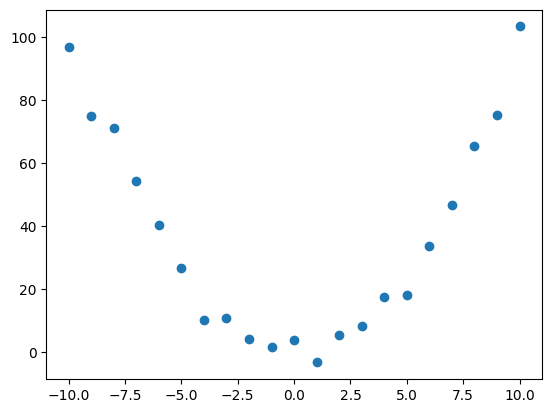

In [4]:
eps = np.random.normal(0, 3, 21)
x = np.asarray(list(range(-10, 11)))
y = x ** 2 + eps

plt.scatter(x, y)

 Linear regression does not work for non linear data

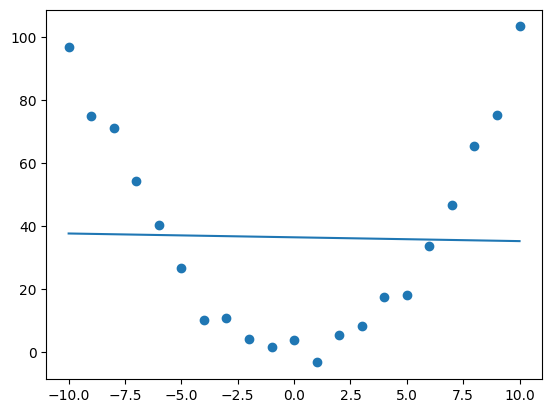

In [5]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1, 1), y)

a = reg.coef_
b = reg.intercept_

pred = [a * v + b for v in x]
plt.scatter(x, y)
plt.plot(x, pred)

If we know the non linearity we can linearize the relationship
by applying it, the resulting problem becomes linear again

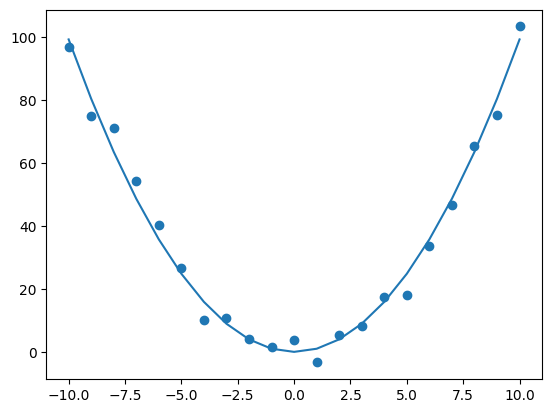

In [6]:
reg = LinearRegression().fit((x ** 2).reshape(-1, 1), y)

a = reg.coef_
b = reg.intercept_

pred = [a * v + b for v in x ** 2]
plt.scatter(x, y)
plt.plot(x, pred)

The problem is: there is an infinity of non linearities and the data can get pretty complex for find non linearity by ourself is not an option. Thankfully Neural Network can approximate any functions and thus learn the non linearity for us.

# Pytorch introduction

## Dataset

In [7]:
from torchvision import datasets
from torchvision import transforms

In [8]:
dataset = datasets.MNIST(
    '../data', 
    train=True, 
    download=True
)
print(len(dataset))

60000


In [9]:
image, label = dataset[0]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

(28, 28) 5


In [10]:
image, label = dataset[1]
image

In [11]:
image, label = dataset[2]
image

Machine learning is all about creating a function `f` that will learn to approximate a function
For classification we want to approximate a function that will recognize the image it has been given in input

$ f(image) -> class\{ 0-9 \}$

## Linear Regression

## Model definition

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


n_class = 10


# x                 : N x 28 x 28
# x = Flatten(x)    : N x 728
# x = Linear(x)     : N x 10      = (N x 728) * (728 x 10) + 1 x 10 
# x = Softmax(x)    : N x 10      


linear = nn.Sequential(
    nn.Flatten(),                  # Flatten images from a 2D matrix to 1D => (28x28) => (784,)
    nn.LazyLinear(n_class),        # Simple (a x + b) layer that will learn `a` and `b`
    nn.Softmax(dim=1)              # Normalization so result wil be between [0, 1]
)

## Prepare Images for the model

In [13]:
image, label = dataset[2]
batch = transforms.ToTensor()(image) # Transform an image to a tensor/matrix

print(image)
print(batch.shape)

<PIL.Image.Image image mode=L size=28x28 at 0x1A0DBBDCB50>
torch.Size([1, 28, 28])


## Make predictions

Of course the model has not been trained yet so the result below are trash.

In [14]:
result = linear(batch)
print('Result:  ', result.shape)

Result:   torch.Size([1, 10])


## Read Predictions

In [15]:
print("\nConfidence of the image to be:")

for v, confidence in enumerate(result.tolist()[0]):
    print(f"  - {v}: {confidence* 100:5.2f}")


prediction = torch.argmax(result)
print('\nPrediction: `', prediction.item(), '` Truth: `', label, '`')


Confidence of the image to be:
  - 0:  9.77
  - 1:  7.57
  - 2:  9.81
  - 3: 13.18
  - 4: 11.65
  - 5: 10.36
  - 6:  7.94
  - 7:  9.58
  - 8: 10.23
  - 9:  9.89

Prediction: ` 3 ` Truth: ` 4 `


# Training

In [16]:
import torch.optim as optim
import torch
import taranis.core.dataset.split as split
from taranis.core.trainer.train import mnist_dataset
from tqdm import tqdm


def newdataloader(batch_size=512):
    # Takes the original dataset and apply transform on the fly
    # Convert image to a tensor
    # normalize the tensor
    dataset_to_use = split.TransformedDatasetClassification(
        dataset, 
        transform=transforms.Compose([                    
            transforms.ToTensor(),                         # Transform the image to tensor
            transforms.Normalize((0.1307,), (0.3081,)),    # Normalize the image
        ])
    )

    # Takes care of spliting the dataset into bite size for our model
    dataloader = torch.utils.data.DataLoader(
        dataset_to_use,
        batch_size = batch_size,
        num_workers = 1,
    )
    
    return dataloader


def train(name, model, epoch=2, lr=0.4):
    batch_size = 512
    dataloader = newdataloader(batch_size)
    
    model = model.cpu()

    # Gradient optimizer 
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    losses = loss_tracker[name]
    
    with tqdm(total=len(dataset) * epoch, ncols=100) as progress:

        # Repeat a few times 
        for i in range(epoch):
            total_loss = 0
            count = 0

            # Go through the dataset
            for batch, labels in dataloader:
    
                optimizer.zero_grad()                     # Clear previous derivative

                probabilities = model(batch)              # Make prediction

                loss = F.nll_loss(probabilities, labels)  # Grade the prediction 

                loss.backward()                           # Compute derivative

                optimizer.step()                          # Update parameters using derivative

                total_loss += loss.item()                 # Keep track of loss to make sure it goes down

                count += 1
                
                progress.update(batch_size)
            
            loss = total_loss / count
            losses.append(loss)
            progress.set_description(f"loss: {loss:8.4f}")
    
    return losses

NOTE: Redirects are currently not supported in Windows or MacOs.


# Train

In [17]:
train('linear', linear, lr=1, epoch=2)

loss:  -0.8829: : 120832it [00:20, 5962.74it/s]                                                     


[-0.7791842109823631, -0.8828744736768431]

## Prediction

In [18]:
image, label = dataset[2]
batch = transforms.ToTensor()(image)

image

In [19]:
result = linear(batch)
print('Result:  ', result.shape)

print("\nConfidence of the image to be:")

for v, confidence in enumerate(result.tolist()[0]):
    print(f"  - {v}: {confidence* 100:5.2f}")


prediction = torch.argmax(result)
print('\nPrediction', prediction.item(), 'Truth:', label)
image

Result:   torch.Size([1, 10])

Confidence of the image to be:
  - 0:  3.20
  - 1:  0.63
  - 2:  5.04
  - 3: 17.85
  - 4: 50.48
  - 5:  1.06
  - 6:  3.21
  - 7:  1.26
  - 8:  6.95
  - 9: 10.31

Prediction 4 Truth: 4


# Non Linearity

Model is linear only so it can only approximate linear relationships
what is we create more layers ?

In [20]:
deepmodel_bad = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(128),    # r1 =  
    nn.LazyLinear(64),     # r2 = (x * a1 + b1) * a2 + b2
    nn.LazyLinear(10),     # r3 = x * w + b
    nn.Softmax(dim=1)      #    w = a1 * a2* a3
                           #    b = b1 * a2* a3 + b2* a3  + b3
)

# r3 = r2 * w3 + b3
# r3 = (r1 * w2 + b2) * w3 + b3
# r3 = r1 * w2 * w3 + b2 * w3  + b3
# r3 = (batch * w1 + b1) * w2 * w3 + b2 * w3  + b3
# r3 = batch * w1 * w2 * w3 + b1 * w2 * w3 + b2 * w3  + b3
#
# r3 = batch * w + b
#  w = w1 * w2 * w3 + b1
#  b =  b1 * w2 * w3 + b2 * w3  + b3
#
#
#   MODEL is still LINEAR
#

batch = transforms.ToTensor()(image)
result = deepmodel_bad(batch)
result.shape

train('deepmodel_bad', deepmodel_bad, lr=1, epoch=2)

loss:  -0.8992: : 120832it [00:20, 6001.04it/s]                                                     


[-0.7868886254096435, -0.8992466077966205]

## Breaking Linearity

In [21]:
#
# Adding non linear function between 
#
deepmodel = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(128),    # r1 = batch * w1 + b1
    nn.ReLU(),             # r2 = max(r1, 0)
    nn.LazyLinear(64),     # r3 = r3 * w3 + b3
    nn.ReLU(),             # r4 = max(r3, 0)
    nn.LazyLinear(10),     # r5 = r4 * w4 + b4
    nn.Softmax(dim=1)  
)

#
# Layers cannot be factorized anymore
#
batch = transforms.ToTensor()(image)
result = deepmodel(batch)

# How does training work ?
train('deepmodel', deepmodel, lr=1, epoch=2)

loss:  -0.9003: : 120832it [00:20, 5947.19it/s]                                                     


[-0.6746835361345339, -0.9002551320245711]

# Mesuring network's precision

In [22]:
def test_model(model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST('../data', train=False,  transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=4096, num_workers=1) 
    
    total = len(dataset)
    model = model.cpu()
    
    with torch.no_grad():
        test_loss = 0
        correct = 0
        
        for batch, labels in loader:
            output = model(batch)
            test_loss += F.nll_loss(output, labels, reduction='sum').item()  
            
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()

        print(f'Accuracy {correct / total * 100:.2f} {100 - correct / total * 100:.2f}')

In [23]:
test_model(linear)
test_model(deepmodel_bad)
test_model(deepmodel)

Accuracy 91.00 9.00
Accuracy 89.47 10.53
Accuracy 91.29 8.71


In [24]:
train('linear',        linear       , lr=1  , epoch=5)
train('deepmodel_bad', deepmodel_bad, lr=1  , epoch=5)
train('deepmodel',     deepmodel    , lr=1  , epoch=5)

loss:  -0.9131: : 302080it [00:50, 5956.74it/s]                                                     
loss:  -0.9220: : 302080it [00:51, 5889.80it/s]                                                     
loss:  -0.9580: : 302080it [00:51, 5853.77it/s]                                                     


[-0.6746835361345339,
 -0.9002551320245711,
 -0.9254565016698029,
 -0.938619072659541,
 -0.9466290807319899,
 -0.9528187351711725,
 -0.9580349235211388]

In [25]:
def show_loss_curve():
    data, mn, mx = get_data()
    return (
        alt.Chart(data)
        .mark_line()
        .encode(
            x=alt.X('epoch'), 
            y=alt.Y("loss", scale=alt.Scale(domain=[mn, mx])), 
            color=alt.Color(
                'model', 
                legend=alt.Legend(
                orient='none',
                legendX=130, legendY=-40,
                direction='horizontal',
                titleAnchor='middle')
            )
        )
    )

show_loss_curve()

alt.Chart(...)

In [26]:
test_model(linear)
test_model(deepmodel_bad)
test_model(deepmodel)

Accuracy 92.14 7.86
Accuracy 91.83 8.17
Accuracy 95.95 4.05


Linear model plateau quickly.
Deeper model can learn more but take longer to train.

# Going faster with GPU

In [27]:
from functools import cache

@cache
def newdataloader_cuda(batch_size=512, train=True):
    dataset_to_use = mnist_dataset(train)
    dataset_to_use.tensors = list(dataset_to_use.tensors)
    for i, t in enumerate(dataset_to_use.tensors):
        dataset_to_use.tensors[i] = t.cuda()

    # Takes care of spliting the dataset into bite size for our model
    dataloader = torch.utils.data.DataLoader(
        dataset_to_use,
        batch_size = batch_size,
        num_workers = 0,
    )
    
    return dataloader


def gpu_train(name, original_model, epoch=2, lr=0.4, batch_size=4096):
    dataloader = newdataloader_cuda(batch_size)        # HERE optimized loader
    device = torch.cuda.current_device()               # HERE Get GPU device
    model = original_model.to(device)                  # HERE Convert model to GPU
    
    optimizer = optim.Adadelta(model.parameters(), lr=1)
    losses = loss_tracker[name]
    
    with tqdm(total=len(dataset) * epoch, ncols=100) as progress:
        for i in range(epoch):
            partial_losses = []
            count = 0
            for batch, labels in dataloader:
                batch, labels = batch.to(device), labels.to(device) # HERE: Convert input to GPU

                optimizer.zero_grad()

                probabilities = model(batch)

                loss = F.nll_loss(probabilities, labels)

                loss.backward()

                optimizer.step()

                partial_losses.append(loss.detach())
                count += 1
                
                progress.update(batch_size)

            total_loss = (sum(partial_losses) / count).item()
            losses.append(total_loss)
            progress.set_description(f"loss: {total_loss:8.4f}")
    
    return losses
    
def gpu_test_model(model, batch_size=4096*2):
    dataloader = newdataloader_cuda(batch_size, train=False)     # HERE optimized loader
    total = len(dataloader.dataset)
    
    device = torch.cuda.current_device()  # HERE
    model = model.to(device=device)       # HERE
    
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total_count = 0
        
        for batch, labels in dataloader:
            batch, labels = batch.to(device), labels.to(device) # HERE
            
            output = model(batch)
            test_loss += F.nll_loss(output, labels, reduction='sum').item() 
            
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total_count += batch.shape[0]

        assert total_count == total, f"{total_count} != {total}"
        print('Accuracy', correct / total * 100, 100 - correct / total * 100)

In [28]:
gpu_train('linear'       , linear       , lr=0.5, epoch=5)
gpu_train('deepmodel_bad', deepmodel_bad, lr=0.5, epoch=5)
gpu_train('deepmodel'    , deepmodel    , lr=0.5, epoch=5)

loss:  -0.9177: : 307200it [00:04, 76043.52it/s]                                                    
loss:  -0.9313: : 307200it [00:02, 112502.31it/s]                                                   
loss:  -0.9674: : 307200it [00:02, 116913.32it/s]                                                   


[-0.6746835361345339,
 -0.9002551320245711,
 -0.9254565016698029,
 -0.938619072659541,
 -0.9466290807319899,
 -0.9528187351711725,
 -0.9580349235211388,
 -0.9636049270629883,
 -0.9650120735168457,
 -0.965933084487915,
 -0.9667143225669861,
 -0.9673980474472046]

In [29]:
show_loss_curve()

alt.Chart(...)

In [30]:
gpu_test_model(linear       )
gpu_test_model(deepmodel_bad)
gpu_test_model(deepmodel    )

Accuracy 92.57 7.430000000000007
Accuracy 92.72 7.280000000000001
Accuracy 96.39 3.6099999999999994


In [31]:
def trainfast(*args, **kwargs):
    if torch.cuda.is_available():
        return gpu_train(*args, **kwargs)
    return train(*args, **kwargs)

def testfast(*args, **kwargs):
    if torch.cuda.is_available():
        return test_model(*args, **kwargs)
    return gpu_test_model(*args, **kwargs)

# Different Layers

Linear layers are quite resource intensive often we will use specialized layer for some specific data.
For example, images will often use convolution layers.

Convolution apply a filter on an image and produce another image https://fr.wikipedia.org/wiki/Noyau_(traitement_d%27image)

In [32]:
image, label = dataset[2]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

(28, 28) 4


In [33]:
conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
print(conv.weight.shape)

batch = transforms.ToTensor()(image)
print(batch.shape)
result = conv(batch)
print(result.shape)

torch.Size([32, 1, 3, 3])
torch.Size([1, 28, 28])
torch.Size([32, 26, 26])


Example of images generated from a convolution

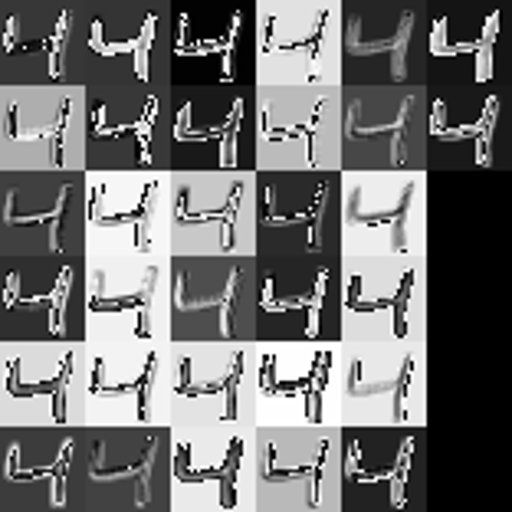

In [34]:
import taranis.core.visualization as viz 
transforms.ToPILImage()(viz.show_conv_layers(result)).resize((512, 512))

# New network with a convolution layer

From a single image it is going to learn to generate 32 new ones to better classify them

In [40]:
from torch.nn import init
from torch import Tensor
import math

import taranis.core.nn as ext_nn
        
conv_model = nn.Sequential(
    # ext_nn.MaskLayer((28, 28)),
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, 1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(576 * 64, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1),
)

batch = transforms.ToTensor()(image).unsqueeze(0)
batch = torch.concat([batch, batch])
conv_model(batch).shape

torch.Size([2, 10])

## Training

In [41]:
trainfast('conv_model', conv_model, lr=1, epoch=2)
trainfast('conv_model', conv_model, lr=1, epoch=5)
trainfast('conv_model', conv_model, lr=1, epoch=5)
trainfast('conv_model', conv_model, lr=1, epoch=5)
trainfast('conv_model', conv_model, lr=0.5, epoch=5)

loss:  -0.3711: : 122880it [00:29, 4210.20it/s]                                                     
loss:  -0.5871: : 307200it [01:11, 4268.31it/s]                                                     
loss:  -0.5951: : 307200it [01:08, 4516.53it/s]                                                     
loss:  -0.7694: : 307200it [01:11, 4294.62it/s]                                                     
loss:  -0.8808: : 307200it [01:15, 4088.42it/s]                                                     


[-0.29688623547554016,
 -0.5393997430801392,
 -0.5732952356338501,
 -0.607652485370636,
 -0.6921831369400024,
 -0.7521690726280212,
 -0.7608457207679749,
 -0.7846342325210571,
 -0.8230769038200378,
 -0.8549892902374268,
 -0.8599054217338562,
 -0.864036500453949,
 -0.8610671162605286,
 -0.871707022190094,
 -0.8754636645317078,
 -0.8767919540405273,
 -0.8785398602485657,
 -0.1952829360961914,
 -0.37109386920928955,
 -0.553053617477417,
 -0.571423351764679,
 -0.579602062702179,
 -0.5830450654029846,
 -0.5871488451957703,
 -0.5839734673500061,
 -0.5908416509628296,
 -0.5924564003944397,
 -0.5944522023200989,
 -0.5951374769210815,
 -0.6119498014450073,
 -0.7229943871498108,
 -0.7610520720481873,
 -0.764756977558136,
 -0.7693565487861633,
 -0.7643980979919434,
 -0.8277541399002075,
 -0.8746568560600281,
 -0.8784070014953613,
 -0.8808184862136841]

## Compare

In [42]:
show_loss_curve()

alt.Chart(...)

In [43]:
testfast(linear)
testfast(deepmodel_bad)
testfast(deepmodel)
testfast(conv_model)

Accuracy 92.57 7.43
Accuracy 92.72 7.28
Accuracy 96.39 3.61
Accuracy 88.14 11.86


## Inspect learned Convolution Kernels

torch.Size([32, 26, 26])


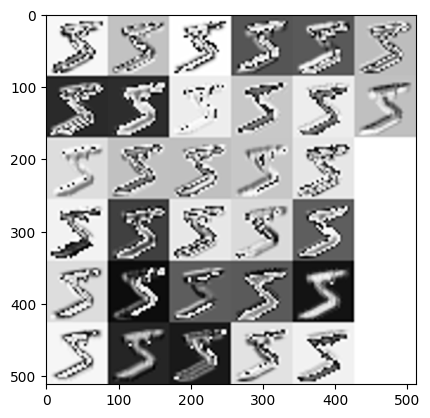

torch.Size([32, 26, 26])


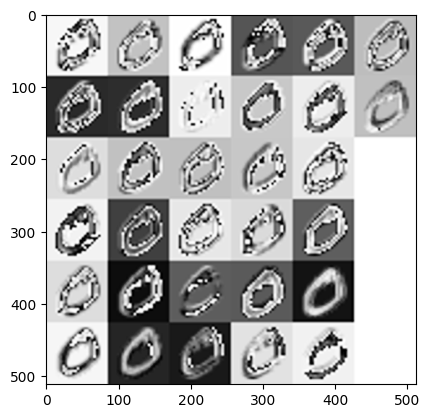

torch.Size([32, 26, 26])


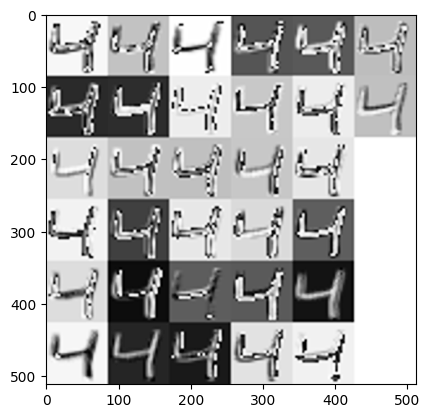

torch.Size([32, 26, 26])


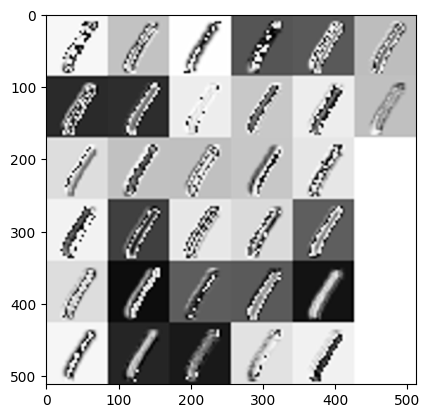

In [44]:
conv_model = conv_model.cpu()

for i in range(4):
    image, label = dataset[i]
    conv = list(conv_model.children())[0]

    batch = transforms.ToTensor()(image)
    result = conv(batch)
    print(result.shape)
    plt.imshow(transforms.ToPILImage()(viz.show_conv_layers(result)).resize((512, 512)), cmap='Greys')
    plt.show()

None torch.Size([1, 1, 28, 28])


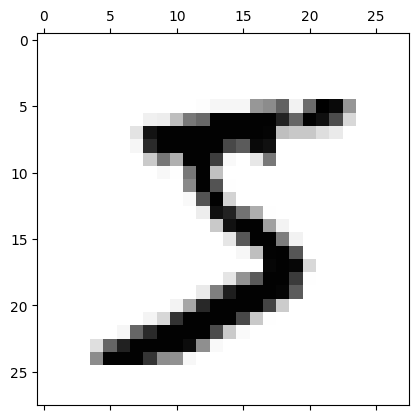

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


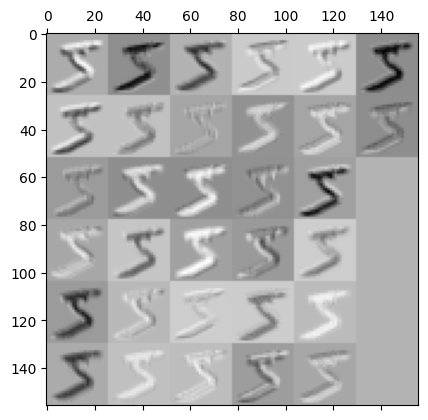

ReLU() torch.Size([1, 32, 26, 26])


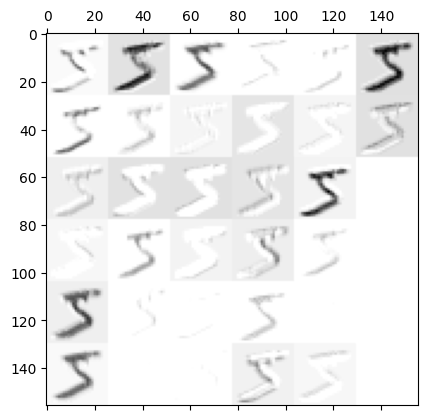

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


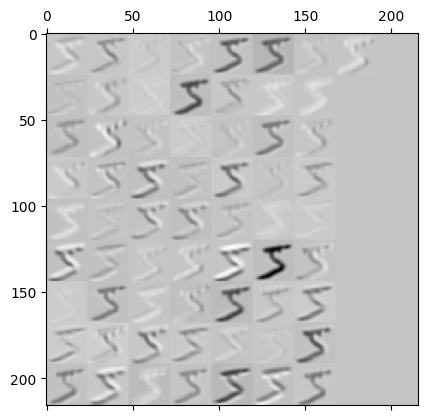

ReLU() torch.Size([1, 64, 24, 24])


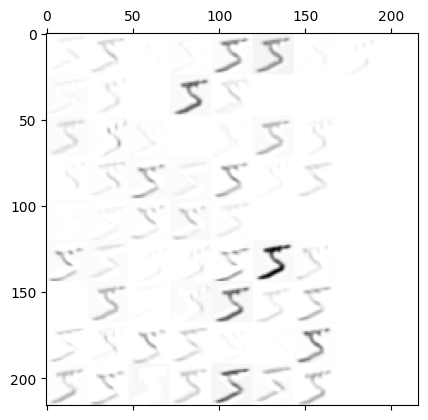

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


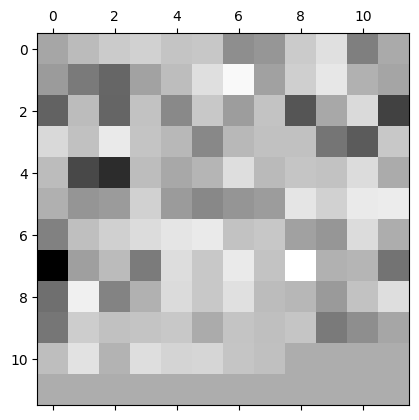

ReLU() torch.Size([1, 128])


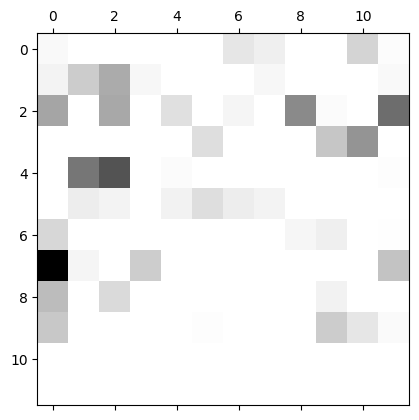

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


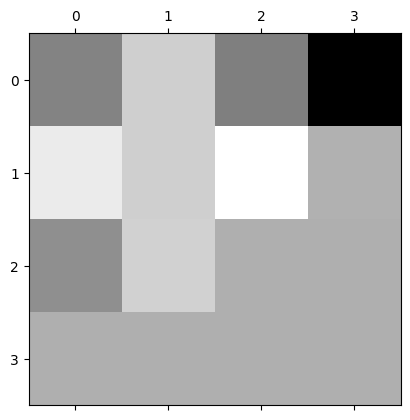

Softmax(dim=1) torch.Size([1, 10])


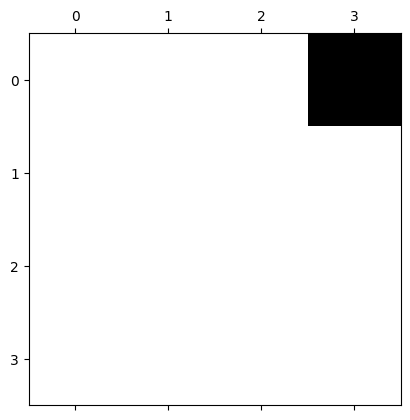

None torch.Size([1, 1, 28, 28])


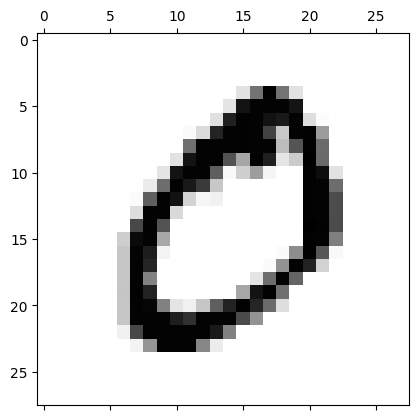

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


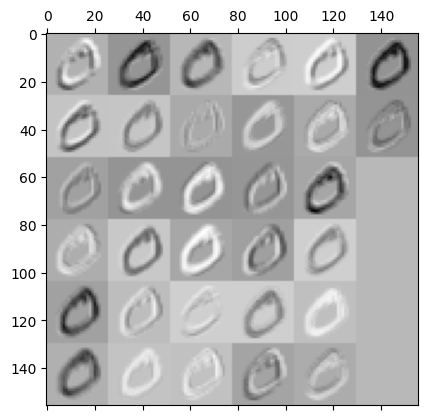

ReLU() torch.Size([1, 32, 26, 26])


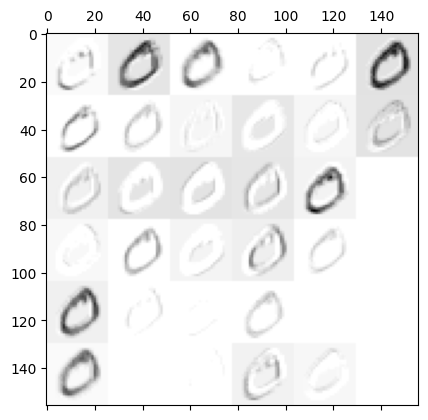

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


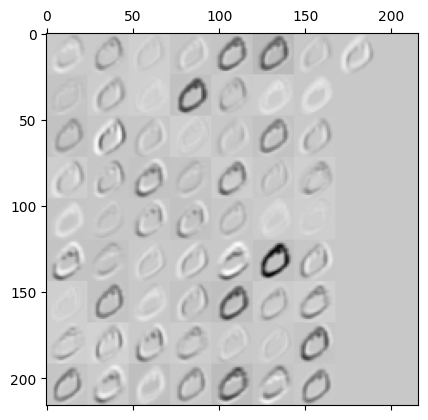

ReLU() torch.Size([1, 64, 24, 24])


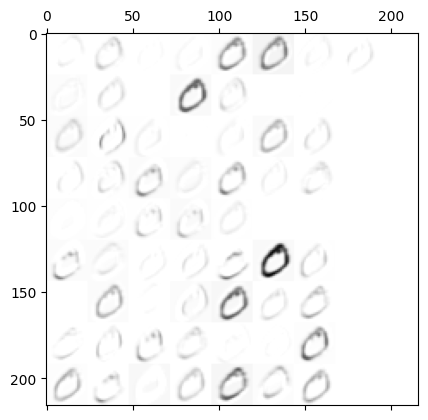

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


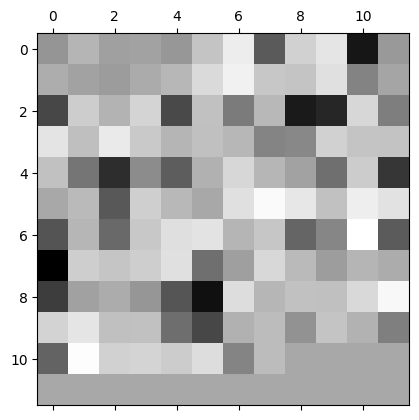

ReLU() torch.Size([1, 128])


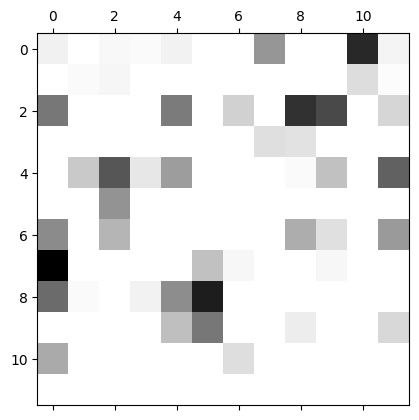

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


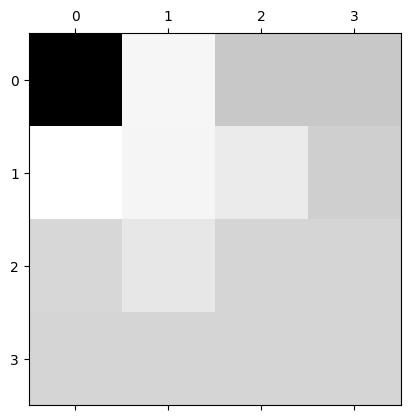

Softmax(dim=1) torch.Size([1, 10])


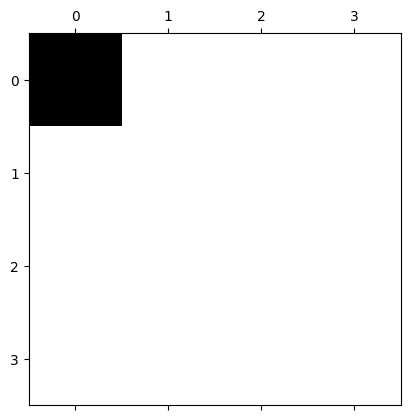

None torch.Size([1, 1, 28, 28])


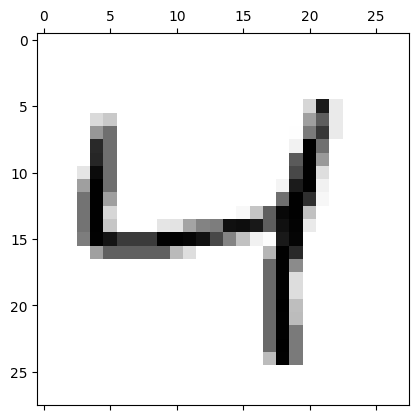

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


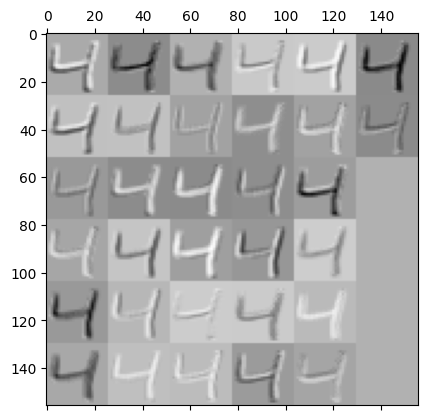

ReLU() torch.Size([1, 32, 26, 26])


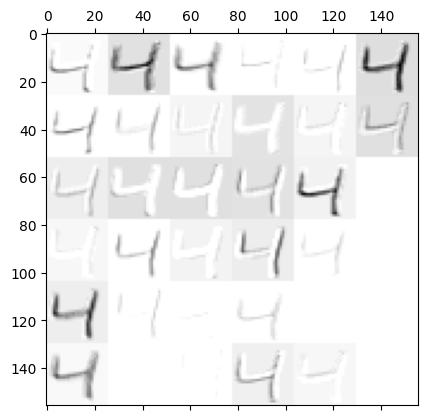

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


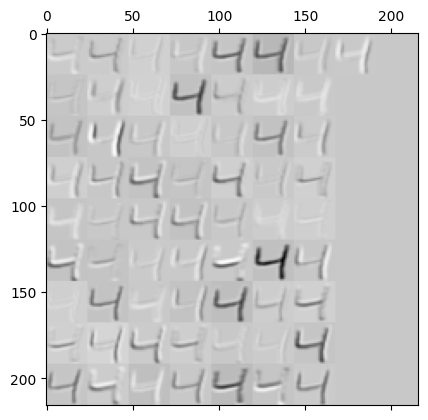

ReLU() torch.Size([1, 64, 24, 24])


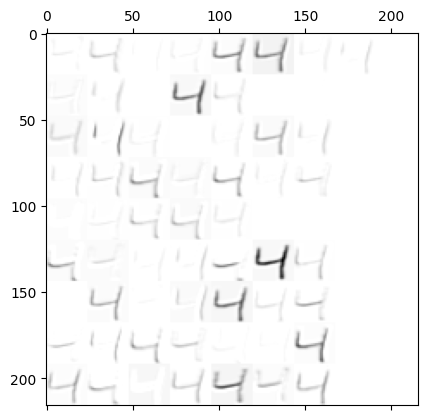

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


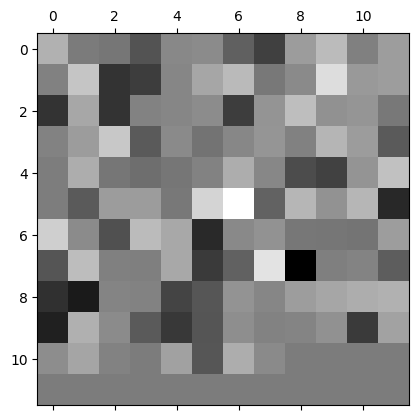

ReLU() torch.Size([1, 128])


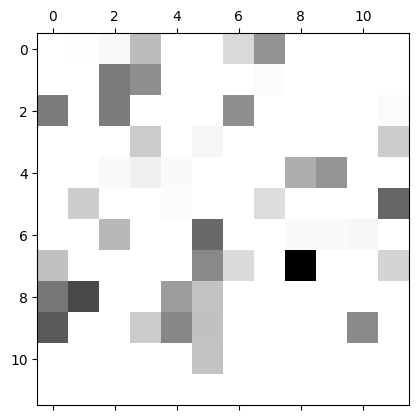

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


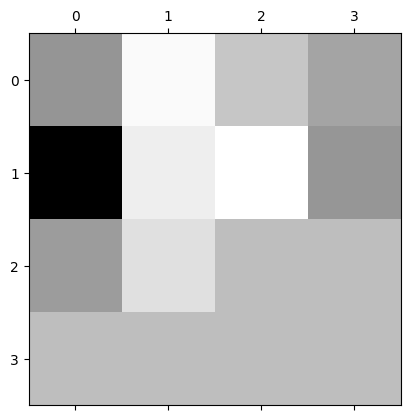

Softmax(dim=1) torch.Size([1, 10])


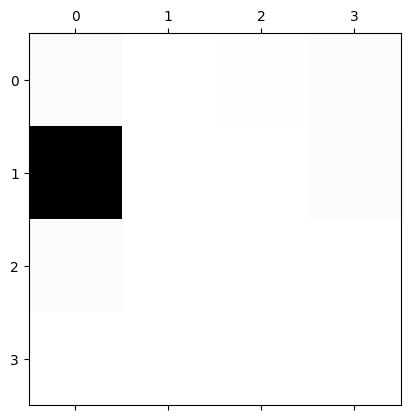

None torch.Size([1, 1, 28, 28])


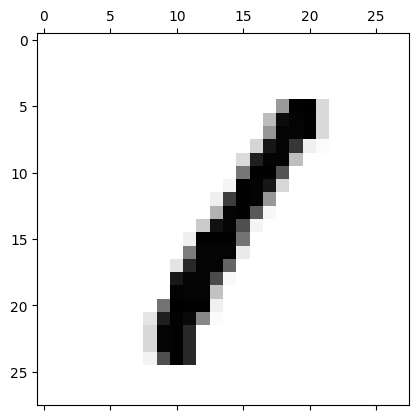

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


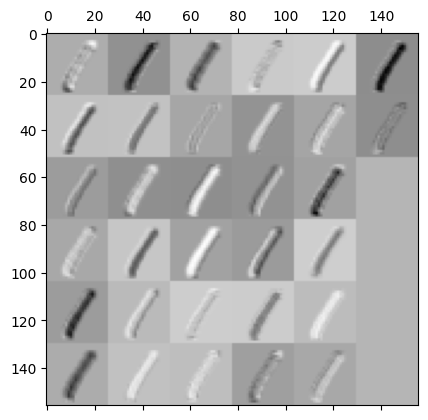

ReLU() torch.Size([1, 32, 26, 26])


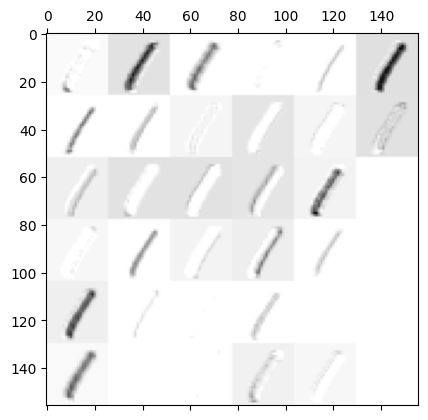

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


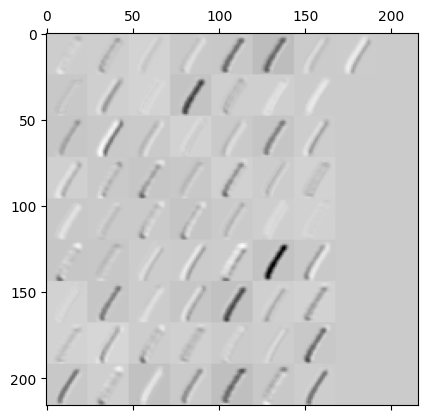

ReLU() torch.Size([1, 64, 24, 24])


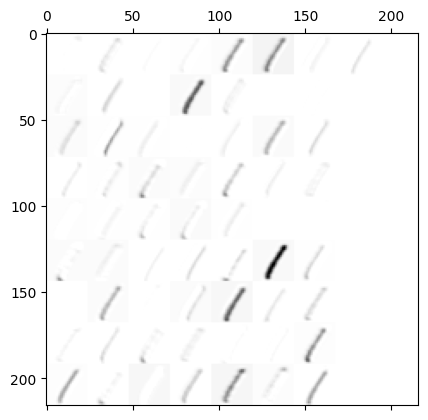

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


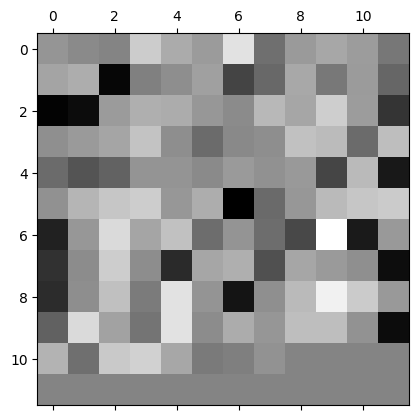

ReLU() torch.Size([1, 128])


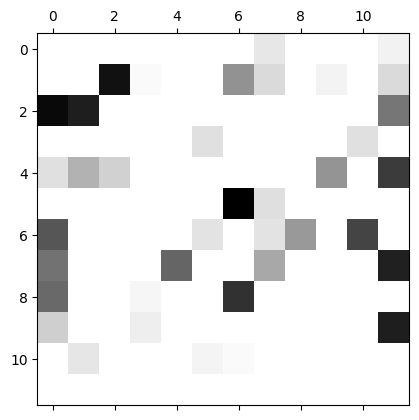

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


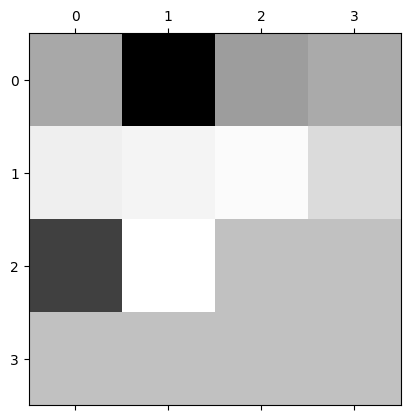

Softmax(dim=1) torch.Size([1, 10])


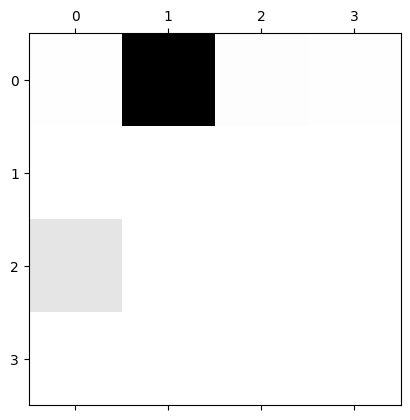

None torch.Size([1, 1, 28, 28])


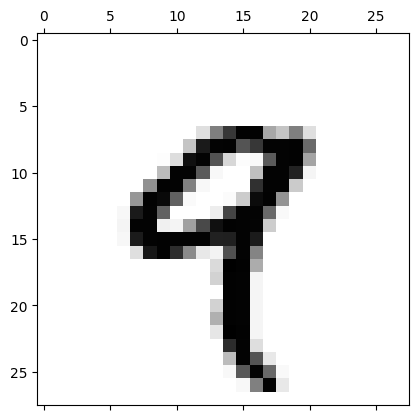

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


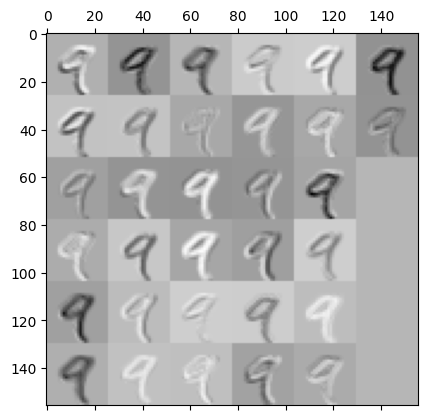

ReLU() torch.Size([1, 32, 26, 26])


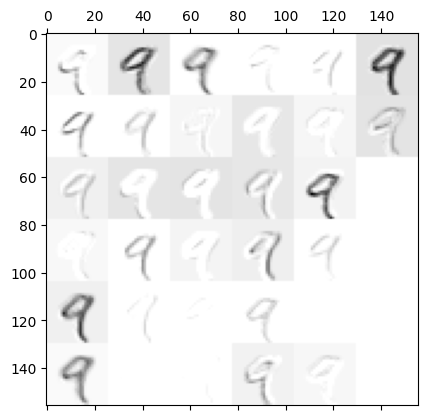

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


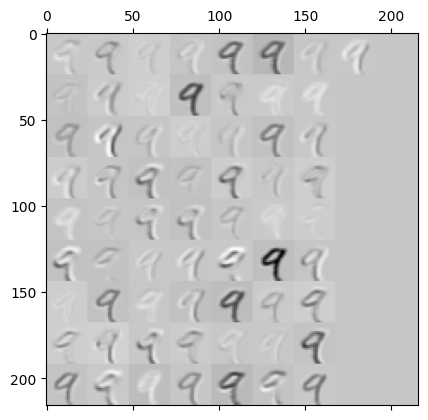

ReLU() torch.Size([1, 64, 24, 24])


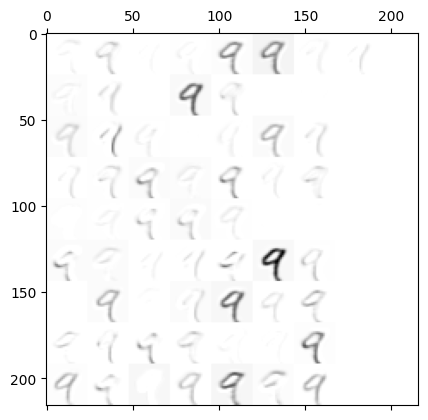

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


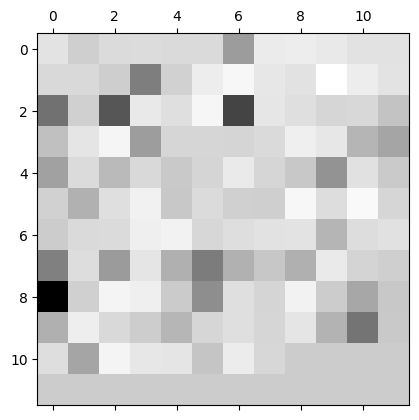

ReLU() torch.Size([1, 128])


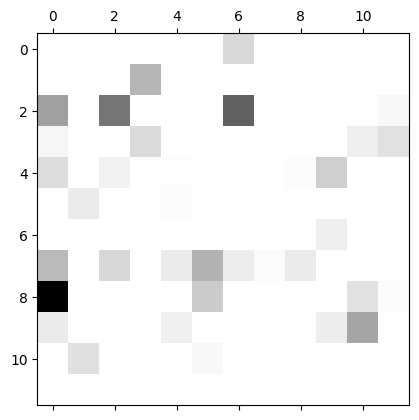

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


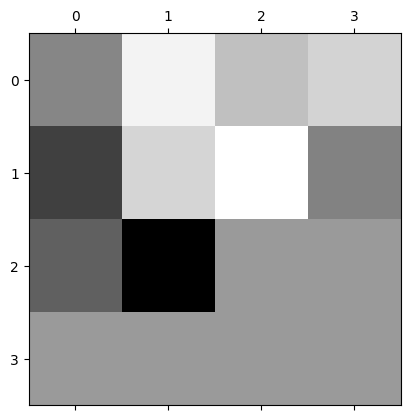

Softmax(dim=1) torch.Size([1, 10])


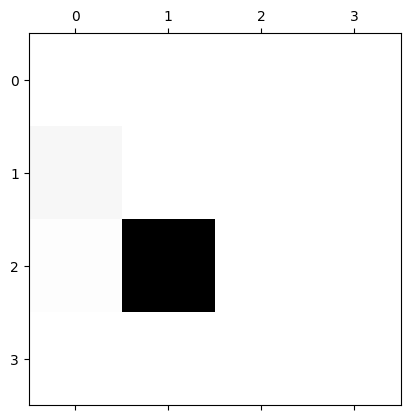

In [45]:
importlib.reload(viz)
viz.show_steps(conv_model, dataset)

# Back to x^2

In [46]:
model = nn.Sequential(
    nn.Linear(1, 2),  
    nn.ReLU(),             
    nn.Linear(2, 1), 
)

list(model.parameters())

[Parameter containing:
 tensor([[0.8119],
         [0.3993]], requires_grad=True),
 Parameter containing:
 tensor([-0.4095,  0.1186], requires_grad=True),
 Parameter containing:
 tensor([[-0.0726,  0.5647]], requires_grad=True),
 Parameter containing:
 tensor([0.6005], requires_grad=True)]

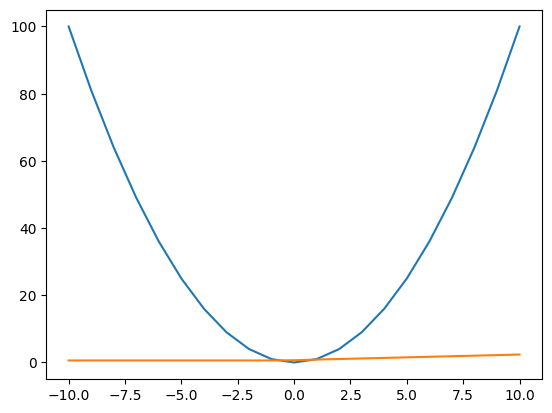

In [48]:
x = np.asarray(list(range(-10, 11)))
y = x ** 2

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
output = torch.tensor(y, dtype=torch.float).unsqueeze(1)
pred = model(input).detach().numpy()

plt.plot(x, y)
plt.plot(x, pred)

In [49]:
def train_reg(model, epoch=100):
    optimizer = optim.Adadelta(model.parameters(), lr=1)

    for i in range(epoch):
        optimizer.zero_grad()
        pred = model(input)
        loss = F.mse_loss(pred, output)
        loss.backward()
        optimizer.step()

        if i % (epoch / 10) == 0:
            print(loss.item())
            
train_reg(model, 2000)

2318.65673828125
1286.4388427734375
1211.706787109375
1130.5809326171875
1074.4512939453125
1022.791748046875
976.1593017578125
934.2945556640625
896.5003051757812
863.95166015625


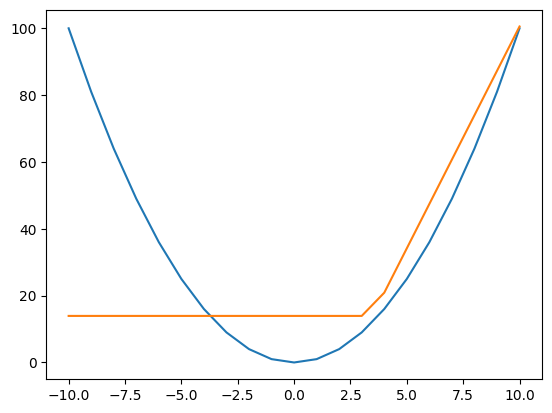

In [50]:
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# Increase number of neurons

2438.56298828125
59.53608703613281
33.291988372802734
27.481689453125
22.26044273376465
16.560701370239258
14.520713806152344
11.997773170471191
10.113697052001953
8.694727897644043


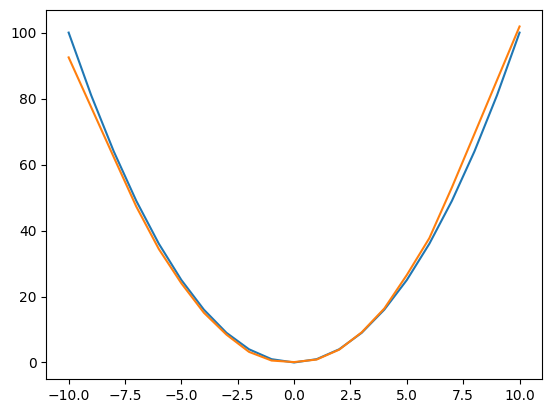

In [51]:
model = nn.Sequential(
    nn.Linear(1, 128),  
    nn.ReLU(),             
    nn.Linear(128, 1), 
)
train_reg(model, 2000)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# Non Linear correlation

In [52]:
# Regular linear Correlation does not work well shows x, y are essentially not correlated
print(np.corrcoef(x, y))

[[ 1.00000000e+00 -2.73542223e-17]
 [-2.73542223e-17  1.00000000e+00]]


In [53]:
pred = model(input).detach().squeeze().numpy()

#
# Correlation is essentially one
#
print(np.corrcoef(pred, y))

[[1.         0.99652271]
 [0.99652271 1.        ]]


# Generalization

Current models are not able to learn or infer outside of the training set
if we increase the domain of the function from $[-10, 10]$ we can see that the error will keep increasing.

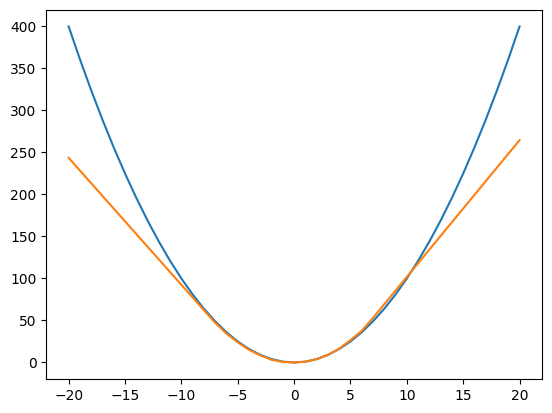

In [54]:
x = np.asarray(list(range(-20, 21)))
y = x ** 2

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# With sin the issue is more obvious

1.5169559717178345
0.023301471024751663
0.016951806843280792
0.012564016506075859
0.009549368172883987
0.007394129876047373
0.005888299085199833
0.004808499943464994
0.004037737846374512
0.003474585711956024


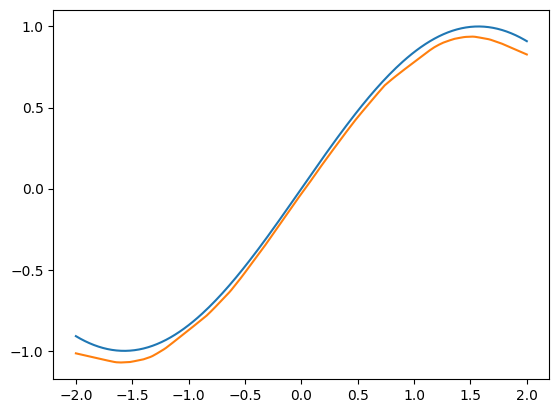

In [55]:
x = np.asarray(list(range(-100, 101))) / 50
y = np.sin(x)

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
output = torch.tensor(y, dtype=torch.float).unsqueeze(1)

model = nn.Sequential(
    nn.Linear(1, 128),  
    nn.ReLU(),             
    nn.Linear(128, 1), 
)

train_reg(model, 2000)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

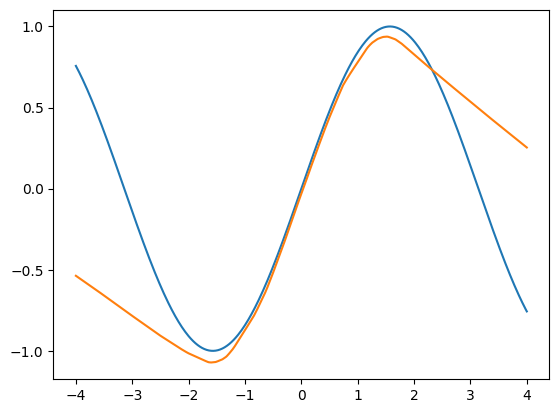

In [56]:
x = np.asarray(list(range(-200, 201))) / 50
y = np.sin(x)

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

0.5839539170265198
0.14220447838306427
0.08847204595804214
0.057840313762426376
0.040213510394096375
0.030536524951457977
0.02536948211491108
0.023714443668723106
0.02376599609851837
0.025334790349006653


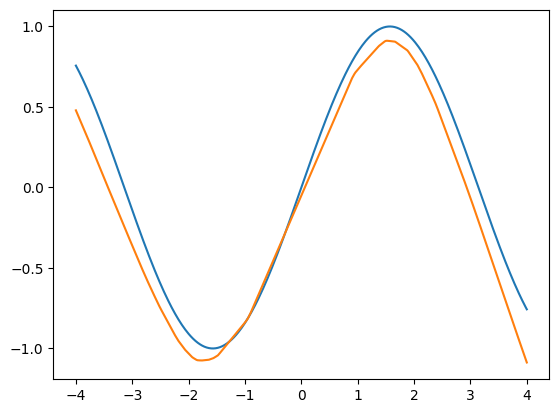

In [57]:
x = np.asarray(list(range(-200, 201))) / 50
y = np.sin(x)

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
output = torch.tensor(y, dtype=torch.float).unsqueeze(1)

model = nn.Sequential(
    nn.Linear(1, 256),  
    nn.ReLU(),             
    nn.Linear(256, 1), 
)

train_reg(model, 2000)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)